<a href="https://colab.research.google.com/github/maulanawirawan/Mandible-Segmentation/blob/main/Mandible_Segmentasi_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install einops
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 540.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=16bbb841207a136bba40206eeea224af9f354e78bcb275eda86449c4c381320a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=55a9883fe19ae37d2fe7611a1696f34d4b5d8bf67a54b4bc54d5c571272ab70f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [ ]:
# Mengaitkan dan mengakses Google Drive ke dalam lingkungan kerja Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Mengekstrak isi dari file zip DentalPanoramicXrays ke dalam direktori saat ini di Colab
!unzip -o /content/drive/MyDrive/ProjectMandible/DentalPanoramicXrays.zip


Archive:  /content/drive/MyDrive/ProjectMandible/DentalPanoramicXrays.zip
   creating: Segmentation2/
  inflating: Segmentation2/1.png     
  inflating: Segmentation2/10.png    
  inflating: Segmentation2/100.png   
  inflating: Segmentation2/101.png   
  inflating: Segmentation2/102.png   
  inflating: Segmentation2/103.png   
  inflating: Segmentation2/104.png   
  inflating: Segmentation2/105.png   
  inflating: Segmentation2/106.png   
  inflating: Segmentation2/107.png   
  inflating: Segmentation2/108.png   
  inflating: Segmentation2/109.png   
  inflating: Segmentation2/11.png    
  inflating: Segmentation2/110.png   
  inflating: Segmentation2/111.png   
  inflating: Segmentation2/112.png   
  inflating: Segmentation2/113.png   
  inflating: Segmentation2/114.png   
  inflating: Segmentation2/115.png   
  inflating: Segmentation2/116.png   
  inflating: Segmentation2/12.png    
  inflating: Segmentation2/13.png    
  inflating: Segmentation2/14.png    
  inflating: Segmentatio

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
from torchvision.transforms import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from segmentation_models_pytorch.losses import DiceLoss
import segmentation_models_pytorch as smp

In [ ]:
from dataclasses import dataclass

@dataclass
class Args:
    model: str = 'unet'
    epochs: int = 100
    batch_size: int = 1
    learning_rate: float = 1e-5
    path_to_images: str = '/content/Images'
    path_to_masks: str = '/content/Segmentation1'
    scale: float = 0.3

args = Args()

def pad(img, divisor=32):
    height, width = img.shape[:2]
    return img[:height - height % divisor, :width - width % divisor]

In [ ]:
class MandibleDataset(Dataset):
    def __init__(self, path_to_images,path_to_masks, transform=None):
        self.path_to_images = path_to_images
        self.path_to_masks= path_to_masks
        self.transform = transform
        self.images = []
        self.masks = []
        for filename in os.listdir(self.path_to_images):
            img = cv2.imread(os.path.join(self.path_to_images, filename), 0)
            img=cv2.resize(img , (928,416))
            img=pad(img)
            img-=img.min()
            img = img.astype(np.float32) / img.max()
            self.images.append(img)
        i=-1
        for filename in os.listdir(self.path_to_masks):
            i+=1
            mask = cv2.imread(os.path.join(self.path_to_masks, filename), 0)
            mask=cv2.resize(mask , (928,416))
            mask=pad(mask)
            mask-=mask.min()
            mask = mask.astype(np.float32) / mask.max()
            mask=np.where(mask==np.unique(mask)[0],0,1)
            self.masks.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform is not None:
            image = self.transform(image).to(device).contiguous()
            mask = self.transform(mask).to(device).contiguous()
        return image, mask

def Dice(output,target,weight=None, eps=1e-5):
    target = target.float()
    if weight is None:
        num = 2 * (output * target).sum()
        den = output.sum() + target.sum() + eps
    return 1.0 - num/den


In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    total_dice = 0
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        target=target.squeeze(1).long()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        total_dice +=Dice(output[:,0,:,:], target).item()
    train_loss /= len(train_loader)
    total_dice /= len(train_loader)
    return train_loss, total_dice

In [ ]:
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    total_dice = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target=target.squeeze(1).long()
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            total_dice += Dice(output[:,0,:,:], target).item()
    val_loss /= len(val_loader)
    total_dice /= len(val_loader)
    return val_loss, total_dice

In [ ]:
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
def plot_dice(train_dice, val_dice):
    plt.plot(train_dice, label='Train dice score')
    plt.plot(val_dice, label='Validation dice score')
    plt.title('Train and Validation Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice score')
    plt.legend()
    plt.show()


In [ ]:
def train_model(model,epochs,batch_size,learning_rate,device):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    criterion = DiceLoss('multiclass')
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    dataset = MandibleDataset(args.path_to_images,args.path_to_masks, transform=transform)
    n_val = int(len(dataset) * 0.2)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(13))
    train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True)
    train_loss_list = []
    val_loss_list = []
    train_dice_list = []
    val_dice_list = []
    min_val_loss=1000
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        train_loss, train_dice = train(model, device, train_loader, optimizer, criterion)
        print('Train loss: {:.6f}, Train dice score: {:.6f}'.format(train_loss, train_dice))
        val_loss, val_dice = validate(model, device, val_loader, criterion)
        print('Validation loss: {:.6f}, Validation dice score: {:.6f}'.format(val_loss, val_dice))
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_dice_list.append(train_dice)
        val_dice_list.append(val_dice)
        torch.save(model.state_dict(), 'checkpoints/{}_model_epoch{}.pth'.format(args.model,epoch+1))
        if val_loss<min_val_loss:
            min_val_loss=val_loss
            torch.save(model.state_dict(), 'checkpoints/{}_model_best.pth'.format(args.model))
    plot_loss(train_loss_list, val_loss_list)
    plot_dice(train_dice_list, val_dice_list)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 190MB/s]


Epoch 1/100


100%|██████████| 93/93 [00:11<00:00,  7.96it/s]


Train loss: 0.430553, Train dice score: 0.780969
Validation loss: 0.402991, Validation dice score: 0.839128
Epoch 2/100


100%|██████████| 93/93 [00:11<00:00,  7.93it/s]


Train loss: 0.382788, Train dice score: 0.868692
Validation loss: 0.380422, Validation dice score: 0.869722
Epoch 3/100


100%|██████████| 93/93 [00:11<00:00,  8.43it/s]


Train loss: 0.366224, Train dice score: 0.889820
Validation loss: 0.369253, Validation dice score: 0.880668
Epoch 4/100


100%|██████████| 93/93 [00:10<00:00,  8.98it/s]


Train loss: 0.355804, Train dice score: 0.903749
Validation loss: 0.360302, Validation dice score: 0.894622
Epoch 5/100


100%|██████████| 93/93 [00:11<00:00,  8.43it/s]


Train loss: 0.348142, Train dice score: 0.914504
Validation loss: 0.354243, Validation dice score: 0.899558
Epoch 6/100


100%|██████████| 93/93 [00:10<00:00,  8.62it/s]


Train loss: 0.342036, Train dice score: 0.922844
Validation loss: 0.349052, Validation dice score: 0.907635
Epoch 7/100


100%|██████████| 93/93 [00:10<00:00,  9.04it/s]


Train loss: 0.336662, Train dice score: 0.929728
Validation loss: 0.343695, Validation dice score: 0.912604
Epoch 8/100


100%|██████████| 93/93 [00:10<00:00,  8.99it/s]


Train loss: 0.331492, Train dice score: 0.936467
Validation loss: 0.339732, Validation dice score: 0.920823
Epoch 9/100


100%|██████████| 93/93 [00:10<00:00,  9.03it/s]


Train loss: 0.326871, Train dice score: 0.941972
Validation loss: 0.336150, Validation dice score: 0.922077
Epoch 10/100


100%|██████████| 93/93 [00:10<00:00,  8.97it/s]


Train loss: 0.322978, Train dice score: 0.946294
Validation loss: 0.332307, Validation dice score: 0.928368
Epoch 11/100


100%|██████████| 93/93 [00:10<00:00,  8.54it/s]


Train loss: 0.319784, Train dice score: 0.949776
Validation loss: 0.330016, Validation dice score: 0.926530
Epoch 12/100


100%|██████████| 93/93 [00:10<00:00,  8.88it/s]


Train loss: 0.316857, Train dice score: 0.953056
Validation loss: 0.325857, Validation dice score: 0.940630
Epoch 13/100


100%|██████████| 93/93 [00:10<00:00,  8.84it/s]


Train loss: 0.314270, Train dice score: 0.955896
Validation loss: 0.325055, Validation dice score: 0.935691
Epoch 14/100


100%|██████████| 93/93 [00:10<00:00,  8.88it/s]


Train loss: 0.311992, Train dice score: 0.958180
Validation loss: 0.322326, Validation dice score: 0.939514
Epoch 15/100


100%|██████████| 93/93 [00:11<00:00,  8.36it/s]


Train loss: 0.309762, Train dice score: 0.960522
Validation loss: 0.321143, Validation dice score: 0.936920
Epoch 16/100


100%|██████████| 93/93 [00:10<00:00,  8.75it/s]


Train loss: 0.307773, Train dice score: 0.962459
Validation loss: 0.318900, Validation dice score: 0.937839
Epoch 17/100


100%|██████████| 93/93 [00:11<00:00,  8.20it/s]


Train loss: 0.305955, Train dice score: 0.964388
Validation loss: 0.317198, Validation dice score: 0.941223
Epoch 18/100


100%|██████████| 93/93 [00:10<00:00,  8.72it/s]


Train loss: 0.304178, Train dice score: 0.966181
Validation loss: 0.315640, Validation dice score: 0.946302
Epoch 19/100


100%|██████████| 93/93 [00:10<00:00,  8.74it/s]


Train loss: 0.302512, Train dice score: 0.967867
Validation loss: 0.314081, Validation dice score: 0.942179
Epoch 20/100


100%|██████████| 93/93 [00:10<00:00,  8.77it/s]


Train loss: 0.301106, Train dice score: 0.969275
Validation loss: 0.312379, Validation dice score: 0.949122
Epoch 21/100


100%|██████████| 93/93 [00:11<00:00,  8.18it/s]


Train loss: 0.299634, Train dice score: 0.970670
Validation loss: 0.311183, Validation dice score: 0.952428
Epoch 22/100


100%|██████████| 93/93 [00:10<00:00,  8.71it/s]


Train loss: 0.298267, Train dice score: 0.972113
Validation loss: 0.310648, Validation dice score: 0.944693
Epoch 23/100


100%|██████████| 93/93 [00:10<00:00,  8.56it/s]


Train loss: 0.297015, Train dice score: 0.973455
Validation loss: 0.308621, Validation dice score: 0.954743
Epoch 24/100


100%|██████████| 93/93 [00:11<00:00,  7.75it/s]


Train loss: 0.295831, Train dice score: 0.974611
Validation loss: 0.307548, Validation dice score: 0.955744
Epoch 25/100


100%|██████████| 93/93 [00:10<00:00,  8.67it/s]


Train loss: 0.294827, Train dice score: 0.975544
Validation loss: 0.306242, Validation dice score: 0.955607
Epoch 26/100


100%|██████████| 93/93 [00:10<00:00,  8.70it/s]


Train loss: 0.293734, Train dice score: 0.976630
Validation loss: 0.305582, Validation dice score: 0.952112
Epoch 27/100


100%|██████████| 93/93 [00:10<00:00,  8.69it/s]


Train loss: 0.292823, Train dice score: 0.977576
Validation loss: 0.305133, Validation dice score: 0.950600
Epoch 28/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.291800, Train dice score: 0.978689
Validation loss: 0.304222, Validation dice score: 0.953107
Epoch 29/100


100%|██████████| 93/93 [00:10<00:00,  8.49it/s]


Train loss: 0.290946, Train dice score: 0.979507
Validation loss: 0.303617, Validation dice score: 0.955123
Epoch 30/100


100%|██████████| 93/93 [00:11<00:00,  8.39it/s]


Train loss: 0.290176, Train dice score: 0.980380
Validation loss: 0.302697, Validation dice score: 0.954949
Epoch 31/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.289415, Train dice score: 0.981193
Validation loss: 0.302537, Validation dice score: 0.953832
Epoch 32/100


100%|██████████| 93/93 [00:10<00:00,  8.68it/s]


Train loss: 0.288693, Train dice score: 0.981962
Validation loss: 0.301227, Validation dice score: 0.958686
Epoch 33/100


100%|██████████| 93/93 [00:10<00:00,  8.64it/s]


Train loss: 0.288086, Train dice score: 0.982495
Validation loss: 0.300587, Validation dice score: 0.960080
Epoch 34/100


100%|██████████| 93/93 [00:10<00:00,  8.60it/s]


Train loss: 0.287393, Train dice score: 0.983373
Validation loss: 0.300883, Validation dice score: 0.953815
Epoch 35/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.286754, Train dice score: 0.984051
Validation loss: 0.300362, Validation dice score: 0.957011
Epoch 36/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.286271, Train dice score: 0.984631
Validation loss: 0.299027, Validation dice score: 0.957933
Epoch 37/100


100%|██████████| 93/93 [00:10<00:00,  8.67it/s]


Train loss: 0.285688, Train dice score: 0.985201
Validation loss: 0.298085, Validation dice score: 0.960917
Epoch 38/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.285241, Train dice score: 0.985776
Validation loss: 0.297948, Validation dice score: 0.962237
Epoch 39/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.284718, Train dice score: 0.986295
Validation loss: 0.297685, Validation dice score: 0.961363
Epoch 40/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.284277, Train dice score: 0.986874
Validation loss: 0.297291, Validation dice score: 0.957188
Epoch 41/100


100%|██████████| 93/93 [00:11<00:00,  8.41it/s]


Train loss: 0.283942, Train dice score: 0.987284
Validation loss: 0.297428, Validation dice score: 0.957018
Epoch 42/100


100%|██████████| 93/93 [00:10<00:00,  8.65it/s]


Train loss: 0.283470, Train dice score: 0.987730
Validation loss: 0.296938, Validation dice score: 0.959786
Epoch 43/100


100%|██████████| 93/93 [00:10<00:00,  8.67it/s]


Train loss: 0.283133, Train dice score: 0.988260
Validation loss: 0.296351, Validation dice score: 0.960512
Epoch 44/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.282768, Train dice score: 0.988645
Validation loss: 0.296120, Validation dice score: 0.959363
Epoch 45/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.282452, Train dice score: 0.989059
Validation loss: 0.295519, Validation dice score: 0.964555
Epoch 46/100


100%|██████████| 93/93 [00:10<00:00,  8.61it/s]


Train loss: 0.282192, Train dice score: 0.989332
Validation loss: 0.295451, Validation dice score: 0.962850
Epoch 47/100


100%|██████████| 93/93 [00:10<00:00,  8.64it/s]


Train loss: 0.281875, Train dice score: 0.989705
Validation loss: 0.295543, Validation dice score: 0.960331
Epoch 48/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.281557, Train dice score: 0.990141
Validation loss: 0.294919, Validation dice score: 0.960929
Epoch 49/100


100%|██████████| 93/93 [00:10<00:00,  8.62it/s]


Train loss: 0.281342, Train dice score: 0.990420
Validation loss: 0.294066, Validation dice score: 0.966709
Epoch 50/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.281133, Train dice score: 0.990656
Validation loss: 0.294629, Validation dice score: 0.962029
Epoch 51/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.280833, Train dice score: 0.991084
Validation loss: 0.294191, Validation dice score: 0.966281
Epoch 52/100


100%|██████████| 93/93 [00:10<00:00,  8.60it/s]


Train loss: 0.280631, Train dice score: 0.991329
Validation loss: 0.293658, Validation dice score: 0.966529
Epoch 53/100


100%|██████████| 93/93 [00:10<00:00,  8.64it/s]


Train loss: 0.280453, Train dice score: 0.991572
Validation loss: 0.294542, Validation dice score: 0.962971
Epoch 54/100


100%|██████████| 93/93 [00:10<00:00,  8.62it/s]


Train loss: 0.280250, Train dice score: 0.991795
Validation loss: 0.295018, Validation dice score: 0.960398
Epoch 55/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.280048, Train dice score: 0.992094
Validation loss: 0.293842, Validation dice score: 0.964634
Epoch 56/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.279857, Train dice score: 0.992452
Validation loss: 0.293064, Validation dice score: 0.966983
Epoch 57/100


100%|██████████| 93/93 [00:10<00:00,  8.60it/s]


Train loss: 0.279732, Train dice score: 0.992558
Validation loss: 0.293886, Validation dice score: 0.962829
Epoch 58/100


100%|██████████| 93/93 [00:10<00:00,  8.61it/s]


Train loss: 0.279606, Train dice score: 0.992720
Validation loss: 0.292781, Validation dice score: 0.966612
Epoch 59/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.279453, Train dice score: 0.992996
Validation loss: 0.292792, Validation dice score: 0.967820
Epoch 60/100


100%|██████████| 93/93 [00:10<00:00,  8.63it/s]


Train loss: 0.279290, Train dice score: 0.993233
Validation loss: 0.292658, Validation dice score: 0.965739
Epoch 61/100


100%|██████████| 93/93 [00:10<00:00,  8.62it/s]


Train loss: 0.279125, Train dice score: 0.993460
Validation loss: 0.292329, Validation dice score: 0.968354
Epoch 62/100


100%|██████████| 93/93 [00:10<00:00,  8.65it/s]


Train loss: 0.279027, Train dice score: 0.993540
Validation loss: 0.293397, Validation dice score: 0.962872
Epoch 63/100


100%|██████████| 93/93 [00:10<00:00,  8.65it/s]


Train loss: 0.278926, Train dice score: 0.993693
Validation loss: 0.293138, Validation dice score: 0.964745
Epoch 64/100


100%|██████████| 93/93 [00:10<00:00,  8.52it/s]


Train loss: 0.278780, Train dice score: 0.993974
Validation loss: 0.292759, Validation dice score: 0.964248
Epoch 65/100


100%|██████████| 93/93 [00:11<00:00,  8.09it/s]


Train loss: 0.278703, Train dice score: 0.993998
Validation loss: 0.292469, Validation dice score: 0.968770
Epoch 66/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.278595, Train dice score: 0.994231
Validation loss: 0.292286, Validation dice score: 0.967439
Epoch 67/100


100%|██████████| 93/93 [00:10<00:00,  8.52it/s]


Train loss: 0.278499, Train dice score: 0.994323
Validation loss: 0.292527, Validation dice score: 0.967236
Epoch 68/100


100%|██████████| 93/93 [00:10<00:00,  8.54it/s]


Train loss: 0.278379, Train dice score: 0.994519
Validation loss: 0.292615, Validation dice score: 0.967893
Epoch 69/100


100%|██████████| 93/93 [00:10<00:00,  8.54it/s]


Train loss: 0.278332, Train dice score: 0.994652
Validation loss: 0.291730, Validation dice score: 0.967347
Epoch 70/100


100%|██████████| 93/93 [00:11<00:00,  8.31it/s]


Train loss: 0.278221, Train dice score: 0.994820
Validation loss: 0.291522, Validation dice score: 0.967708
Epoch 71/100


100%|██████████| 93/93 [00:10<00:00,  8.56it/s]


Train loss: 0.278149, Train dice score: 0.994914
Validation loss: 0.292187, Validation dice score: 0.965622
Epoch 72/100


100%|██████████| 93/93 [00:10<00:00,  8.58it/s]


Train loss: 0.278143, Train dice score: 0.994858
Validation loss: 0.291823, Validation dice score: 0.969187
Epoch 73/100


100%|██████████| 93/93 [00:10<00:00,  8.56it/s]


Train loss: 0.278031, Train dice score: 0.995072
Validation loss: 0.291012, Validation dice score: 0.971516
Epoch 74/100


100%|██████████| 93/93 [00:10<00:00,  8.61it/s]


Train loss: 0.278010, Train dice score: 0.995091
Validation loss: 0.292131, Validation dice score: 0.964117
Epoch 75/100


100%|██████████| 93/93 [00:10<00:00,  8.56it/s]


Train loss: 0.277853, Train dice score: 0.995331
Validation loss: 0.291781, Validation dice score: 0.968993
Epoch 76/100


100%|██████████| 93/93 [00:10<00:00,  8.54it/s]


Train loss: 0.277856, Train dice score: 0.995343
Validation loss: 0.291235, Validation dice score: 0.969547
Epoch 77/100


100%|██████████| 93/93 [00:10<00:00,  8.55it/s]


Train loss: 0.277763, Train dice score: 0.995550
Validation loss: 0.291734, Validation dice score: 0.967348
Epoch 78/100


100%|██████████| 93/93 [00:10<00:00,  8.54it/s]


Train loss: 0.277718, Train dice score: 0.995590
Validation loss: 0.291766, Validation dice score: 0.969356
Epoch 79/100


100%|██████████| 93/93 [00:10<00:00,  8.52it/s]


Train loss: 0.277677, Train dice score: 0.995675
Validation loss: 0.290836, Validation dice score: 0.971172
Epoch 80/100


100%|██████████| 93/93 [00:10<00:00,  8.59it/s]


Train loss: 0.277571, Train dice score: 0.995826
Validation loss: 0.292437, Validation dice score: 0.965627
Epoch 81/100


100%|██████████| 93/93 [00:10<00:00,  8.56it/s]


Train loss: 0.277599, Train dice score: 0.995732
Validation loss: 0.290905, Validation dice score: 0.968924
Epoch 82/100


100%|██████████| 93/93 [00:10<00:00,  8.55it/s]


Train loss: 0.277519, Train dice score: 0.995868
Validation loss: 0.291972, Validation dice score: 0.967132
Epoch 83/100


100%|██████████| 93/93 [00:10<00:00,  8.57it/s]


Train loss: 0.277474, Train dice score: 0.995954
Validation loss: 0.291584, Validation dice score: 0.968281
Epoch 84/100


100%|██████████| 93/93 [00:10<00:00,  8.57it/s]


Train loss: 0.277411, Train dice score: 0.996125
Validation loss: 0.290739, Validation dice score: 0.969703
Epoch 85/100


100%|██████████| 93/93 [00:10<00:00,  8.60it/s]


Train loss: 0.277414, Train dice score: 0.996064
Validation loss: 0.291504, Validation dice score: 0.965549
Epoch 86/100


100%|██████████| 93/93 [00:11<00:00,  8.06it/s]


Train loss: 0.277385, Train dice score: 0.996118
Validation loss: 0.291782, Validation dice score: 0.964748
Epoch 87/100


100%|██████████| 93/93 [00:11<00:00,  8.20it/s]


Train loss: 0.277309, Train dice score: 0.996211
Validation loss: 0.291345, Validation dice score: 0.968603
Epoch 88/100


100%|██████████| 93/93 [00:10<00:00,  8.58it/s]


Train loss: 0.277264, Train dice score: 0.996302
Validation loss: 0.291112, Validation dice score: 0.968628
Epoch 89/100


100%|██████████| 93/93 [00:10<00:00,  8.56it/s]


Train loss: 0.277247, Train dice score: 0.996374
Validation loss: 0.291166, Validation dice score: 0.966584
Epoch 90/100


100%|██████████| 93/93 [00:10<00:00,  8.53it/s]


Train loss: 0.277234, Train dice score: 0.996356
Validation loss: 0.290760, Validation dice score: 0.970404
Epoch 91/100


100%|██████████| 93/93 [00:10<00:00,  8.58it/s]


Train loss: 0.277188, Train dice score: 0.996419
Validation loss: 0.290922, Validation dice score: 0.969195
Epoch 92/100


100%|██████████| 93/93 [00:10<00:00,  8.53it/s]


Train loss: 0.277152, Train dice score: 0.996479
Validation loss: 0.291135, Validation dice score: 0.968520
Epoch 93/100


100%|██████████| 93/93 [00:10<00:00,  8.53it/s]


Train loss: 0.277135, Train dice score: 0.996494
Validation loss: 0.290986, Validation dice score: 0.970030
Epoch 94/100


100%|██████████| 93/93 [00:10<00:00,  8.55it/s]


Train loss: 0.277069, Train dice score: 0.996622
Validation loss: 0.291034, Validation dice score: 0.968800
Epoch 95/100


100%|██████████| 93/93 [00:10<00:00,  8.55it/s]


Train loss: 0.277083, Train dice score: 0.996558
Validation loss: 0.291277, Validation dice score: 0.967808
Epoch 96/100


100%|██████████| 93/93 [00:10<00:00,  8.58it/s]


Train loss: 0.277018, Train dice score: 0.996737
Validation loss: 0.290614, Validation dice score: 0.969224
Epoch 97/100


100%|██████████| 93/93 [00:10<00:00,  8.58it/s]


Train loss: 0.277019, Train dice score: 0.996683
Validation loss: 0.290827, Validation dice score: 0.969169
Epoch 98/100


100%|██████████| 93/93 [00:10<00:00,  8.53it/s]


Train loss: 0.276968, Train dice score: 0.996800
Validation loss: 0.291182, Validation dice score: 0.965979
Epoch 99/100


100%|██████████| 93/93 [00:10<00:00,  8.51it/s]


Train loss: 0.276968, Train dice score: 0.996751
Validation loss: 0.290743, Validation dice score: 0.969399
Epoch 100/100


100%|██████████| 93/93 [00:11<00:00,  7.89it/s]


Train loss: 0.276935, Train dice score: 0.996841
Validation loss: 0.291224, Validation dice score: 0.967022


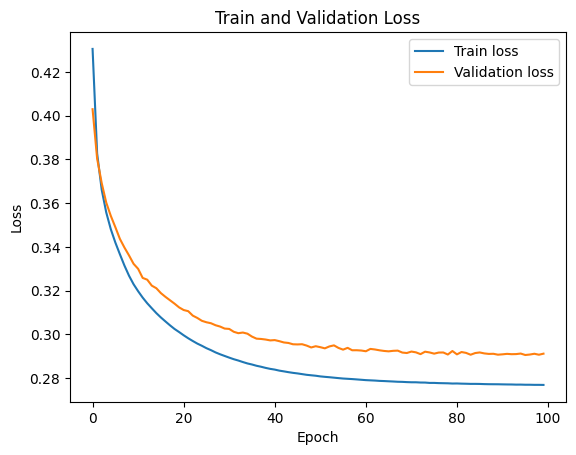

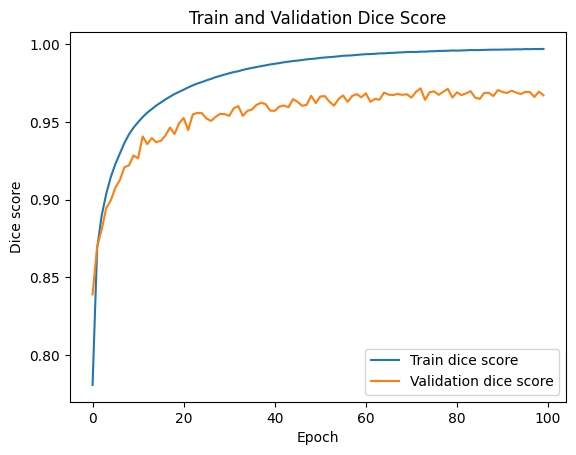

In [ ]:
if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if args.model=='unet':
        model = smp.Unet(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='unet++':
        model = smp.UnetPlusPlus(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    if args.model=='FPN':
        model = smp.FPN(
            encoder_name="resnet34",
            encoder_weights="imagenet",
            in_channels=1,
            classes=2,
            activation='sigmoid'
        )
    model = model.to(memory_format=torch.channels_last)
    model.to(device=device)
    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')
    train_model(
        model=model,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.learning_rate,
        device=device)

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=1,
    classes=2,
    activation='sigmoid'
)
model.load_state_dict(torch.load('checkpoints/unet_model_best.pth', map_location=device))
model.to(device=device)
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
def predict(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    print(f"Original image shape: {img.shape}")  # print the shape of the original image
    img = cv2.resize(img, (928, 416))
    img = img.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)
    mask = prediction.squeeze().cpu().numpy()
    mask = mask / mask.max() # normalize the mask here
    print(f"Mask shape before resize: {mask.shape}")  # print the shape of the mask before resize
    mask = cv2.resize(mask[0, :, :], (img.shape[1], img.shape[0]))  # resize the mask to the original image size
    return mask

In [ ]:
# Perform prediction on an image
image_path = '/content/Images/106.png'
mask = predict(image_path)

Original image shape: (1100, 2800)
Mask shape before resize: (2, 416, 928)


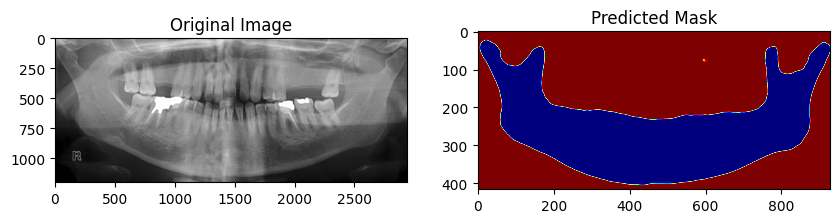

In [ ]:
# Display the original image and predicted mask
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='jet')  # Ubah 'gray' menjadi 'jet'
plt.title('Predicted Mask')
plt.show()

In [ ]:
# Perform prediction on an image
image_path = '/content/Images/13.png'  # replace with your image path
mask = predict(image_path)

Original image shape: (1200, 2940)
Mask shape before resize: (2, 416, 928)


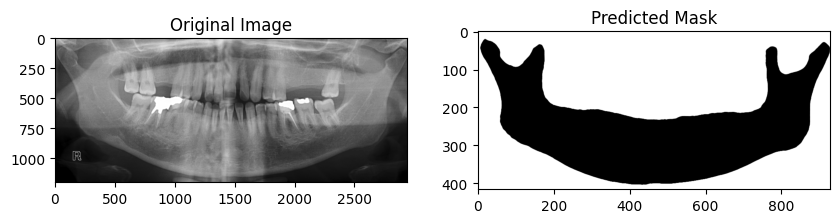

In [ ]:
# Display the original image and predicted mask
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask')
plt.show()

# tambahan
